In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
from sklearn.model_selection import cross_val_predict, RepeatedStratifiedKFold
from warnings import filterwarnings
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
from datetime import datetime
filterwarnings('ignore')


In [5]:
# Load data
do_sample = False
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print("train data shape", train.shape)
print("test data shape", test.shape)


train data shape (250, 302)
test data shape (19750, 301)


In [6]:
train.head(2)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973


In [7]:
train_input = train.drop(['id','target'],axis = 1)
test_input  = test.drop(['id'],axis = 1)
train_cols = train_input.columns
test_cols = test_input.columns

train_labels = train['target']

#app_train = pd.get_dummies(train_input)
#app_test = pd.get_dummies(test_input)

#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp_mean.fit(app_train)
#train_imputed = imp_mean.transform(app_train)
#test_imputed = imp_mean.transform(app_test)

scaler = StandardScaler()
scaler.fit(train_input)
train_imputed = scaler.transform(train_input)
test_imputed = scaler.transform(test_input)
train_df = pd.DataFrame(train_imputed, columns = train_cols)
test_df = pd.DataFrame(test_imputed, columns = test_cols)

In [9]:

features = list(train_df.columns)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train_df,train_labels)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


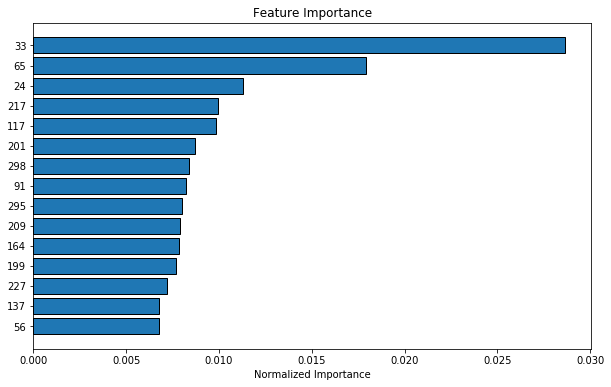

In [10]:
def plot_feature_importances(df):
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    
    return df
feature_importances_sorted = plot_feature_importances(feature_importances)

In [11]:
fe_threshold = 0.001
selected_features = feature_importances_sorted.query('importance_normalized > {}'.format(fe_threshold))['feature'].values
print(selected_features)

['33' '65' '24' '217' '117' '201' '298' '91' '295' '209' '164' '199' '227'
 '137' '56' '268' '214' '43' '144' '80' '189' '266' '139' '48' '230' '111'
 '26' '225' '275' '237' '207' '19' '123' '228' '165' '82' '276' '250'
 '277' '73' '192' '265' '272' '116' '289' '255' '17' '94' '7' '0' '119'
 '156' '12' '131' '285' '169' '147' '242' '247' '16' '170' '149' '240'
 '234' '291' '252' '89' '279' '195' '138' '13' '166' '47' '127' '52' '120'
 '288' '18' '148' '208' '141' '130' '155' '180' '51' '44' '101' '129' '23'
 '113' '37' '150' '132' '173' '202' '76' '239' '58' '163' '257' '215'
 '221' '40' '292' '284' '108' '226' '135' '4' '97' '9' '39' '191' '145'
 '77' '96' '11' '194' '152' '267' '204' '53' '66' '142' '259' '27' '30'
 '160' '231' '270' '98' '248' '42' '8' '278' '110' '185' '114' '256' '153'
 '206' '14' '238' '1' '271' '220' '84' '280' '106' '198' '162' '178' '100'
 '134' '258' '161' '253' '246' '154' '29' '62' '177' '68' '286' '67' '83'
 '200' '236' '78' '122' '118' '21' '171' '151' '1

In [8]:
#target_column ='target'
#id_column = 'id'
#categorical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.object]]
#numerical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
#preprocess = make_column_transformer(
#    (numerical_cols, make_pipeline(SimpleImputer(), StandardScaler())),
#    (categorical_cols, OneHotEncoder()))
#train_input = preprocess.fit_transform(train_input)
#test_input = preprocess.fit_transform(test_input)
#print(type(train_input))

<class 'numpy.ndarray'>


In [12]:
selected_df = pd.DataFrame()
selected_test = pd.DataFrame()
for col in selected_features:
    selected_df[col] = train_df[col]
    selected_test[col] = test_df[col]

In [13]:
def cross_validation(model_, train_, target_):
    
    clfs = []
    folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 20, random_state = 42)
    
    valid_pred = pd.DataFrame(index = train_.index)
    
    # Cross-validation cycle
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(target_, target_)):
        print('--- Fold {} started at {}'.format(n_fold, time.ctime()))
        
        train_x, train_y = train_.iloc[train_idx], target_.iloc[train_idx]
        valid_x, valid_y = train_.iloc[valid_idx], target_.iloc[valid_idx]
        
        
        model_.fit(train_x, train_y)
    
        clfs.append(model_)

        predict = model_.predict_proba(valid_x)[:, 1]
    
        tn, fp, fn, tp = confusion_matrix(valid_y, (predict >= .5) * 1).ravel()
        auc = roc_auc_score(valid_y, predict)
        acc = accuracy_score(valid_y, (predict >= .5) * 1)
        loss = log_loss(valid_y, predict)
        print('TN =', tn, 'FN =', fn, 'FP =', fp, 'TP =', tp)
        print('AUC = ', auc, 'Loss =', loss, 'Acc =', acc)
        
        valid_pred[n_fold] = pd.Series(predict, index = valid_x.index)

        del train_x, train_y, valid_x, valid_y, predict
        gc.collect()

    return clfs, valid_pred

In [14]:
classifiers = {
"model_lgbm" : LGBMClassifier(n_jobs=-1,eta=0.01,max_depth=5,max_bin=512,learning_rate=0.01,num_iterations=1000),
"model_xgb" : XGBClassifier(n_jobs=-1, nthreads=-1),
"model_lr" : LogisticRegression(n_jobs=-1, penalty='l1', C=0.2, class_weight='balanced', solver='saga'),
"model_gnb" : GaussianNB(),
"model_rf" : RandomForestClassifier(n_jobs=-1, random_state=42)
}

In [21]:
def get_fitted_models_and_preds(df, labels, models):
    ret =[]
    for k,v in models.items():
        clfs, pred = cross_validation(v, df, labels)
        
        ret.append({'classifier':k, 'score':pred.mean(axis=1), 'preds':pred.mean(axis=1), 'model': clfs})
        print("model {}: {}".format(k,pred.mean(axis=1)))
    return ret

In [28]:
def predict_models(df, fitted_base_models):
    ret_df = pd.DataFrame()
    for fitted_base_model in fitted_base_models:
        for model in fitted_base_model['model']:
            preds = model.predict_proba(df)
        pred = preds.mean()
        ret_df[fitted_base_model['classifier']] = pred
    return ret_df

In [23]:
base_models_preds_train = get_fitted_models_and_preds(selected_df, train_labels, classifiers)

--- Fold 0 started at Mon Apr 22 15:16:30 2019
TN = 8 FN = 7 FP = 10 TP = 25
AUC =  0.7135416666666667 Loss = 0.7130333960270065 Acc = 0.66
--- Fold 1 started at Mon Apr 22 15:16:30 2019
TN = 9 FN = 6 FP = 9 TP = 26
AUC =  0.6996527777777778 Loss = 0.6688204057958184 Acc = 0.7
--- Fold 2 started at Mon Apr 22 15:16:31 2019
TN = 6 FN = 4 FP = 12 TP = 28
AUC =  0.6215277777777777 Loss = 0.8225796916493348 Acc = 0.68
--- Fold 3 started at Mon Apr 22 15:16:32 2019
TN = 6 FN = 2 FP = 12 TP = 30
AUC =  0.8003472222222223 Loss = 0.6455538705979295 Acc = 0.72
--- Fold 4 started at Mon Apr 22 15:16:32 2019
TN = 4 FN = 4 FP = 14 TP = 28
AUC =  0.6892361111111112 Loss = 0.722543360587448 Acc = 0.64
--- Fold 5 started at Mon Apr 22 15:16:33 2019
TN = 4 FN = 3 FP = 14 TP = 29
AUC =  0.7135416666666667 Loss = 0.6617380031970035 Acc = 0.66
--- Fold 6 started at Mon Apr 22 15:16:34 2019
TN = 5 FN = 8 FP = 13 TP = 24
AUC =  0.5625 Loss = 0.9942820625109833 Acc = 0.58
--- Fold 7 started at Mon Apr 22 15

TN = 9 FN = 4 FP = 9 TP = 28
AUC =  0.7760416666666666 Loss = 0.5692123861302281 Acc = 0.74
--- Fold 60 started at Mon Apr 22 15:17:15 2019
TN = 8 FN = 5 FP = 10 TP = 27
AUC =  0.7638888888888888 Loss = 0.604562049517719 Acc = 0.7
--- Fold 61 started at Mon Apr 22 15:17:15 2019
TN = 4 FN = 7 FP = 14 TP = 25
AUC =  0.5833333333333334 Loss = 0.8919997947218034 Acc = 0.58
--- Fold 62 started at Mon Apr 22 15:17:16 2019
TN = 6 FN = 4 FP = 12 TP = 28
AUC =  0.6996527777777778 Loss = 0.7858677616235242 Acc = 0.68
--- Fold 63 started at Mon Apr 22 15:17:17 2019
TN = 8 FN = 1 FP = 10 TP = 31
AUC =  0.7690972222222222 Loss = 0.5883622667729292 Acc = 0.78
--- Fold 64 started at Mon Apr 22 15:17:18 2019
TN = 7 FN = 6 FP = 11 TP = 26
AUC =  0.71875 Loss = 0.6626816391507162 Acc = 0.66
--- Fold 65 started at Mon Apr 22 15:17:19 2019
TN = 5 FN = 1 FP = 13 TP = 31
AUC =  0.7986111111111112 Loss = 0.5829307399906907 Acc = 0.72
--- Fold 66 started at Mon Apr 22 15:17:19 2019
TN = 4 FN = 6 FP = 14 TP = 

--- Fold 12 started at Mon Apr 22 15:17:50 2019
TN = 12 FN = 4 FP = 6 TP = 28
AUC =  0.7690972222222222 Loss = 0.5955405669100583 Acc = 0.8
--- Fold 13 started at Mon Apr 22 15:17:50 2019
TN = 7 FN = 3 FP = 11 TP = 29
AUC =  0.75 Loss = 0.6111386968754232 Acc = 0.72
--- Fold 14 started at Mon Apr 22 15:17:50 2019
TN = 8 FN = 2 FP = 10 TP = 30
AUC =  0.6961805555555556 Loss = 0.6032161815464496 Acc = 0.76
--- Fold 15 started at Mon Apr 22 15:17:50 2019
TN = 6 FN = 4 FP = 12 TP = 28
AUC =  0.6614583333333333 Loss = 0.6990377793833613 Acc = 0.68
--- Fold 16 started at Mon Apr 22 15:17:50 2019
TN = 11 FN = 7 FP = 7 TP = 25
AUC =  0.7604166666666667 Loss = 0.5729863368719816 Acc = 0.72
--- Fold 17 started at Mon Apr 22 15:17:51 2019
TN = 4 FN = 4 FP = 14 TP = 28
AUC =  0.7274305555555556 Loss = 0.5992094673588872 Acc = 0.64
--- Fold 18 started at Mon Apr 22 15:17:51 2019
TN = 7 FN = 5 FP = 11 TP = 27
AUC =  0.7638888888888888 Loss = 0.5415027780458331 Acc = 0.68
--- Fold 19 started at Mon A

TN = 8 FN = 2 FP = 10 TP = 30
AUC =  0.8385416666666666 Loss = 0.4935785057581961 Acc = 0.76
--- Fold 72 started at Mon Apr 22 15:18:01 2019
TN = 9 FN = 3 FP = 9 TP = 29
AUC =  0.7881944444444444 Loss = 0.5403956609033048 Acc = 0.76
--- Fold 73 started at Mon Apr 22 15:18:01 2019
TN = 6 FN = 8 FP = 12 TP = 24
AUC =  0.6302083333333334 Loss = 0.7409862062707543 Acc = 0.6
--- Fold 74 started at Mon Apr 22 15:18:01 2019
TN = 5 FN = 5 FP = 13 TP = 27
AUC =  0.5902777777777778 Loss = 0.8471939123049378 Acc = 0.64
--- Fold 75 started at Mon Apr 22 15:18:01 2019
TN = 4 FN = 3 FP = 14 TP = 29
AUC =  0.7378472222222222 Loss = 0.6105434928275645 Acc = 0.66
--- Fold 76 started at Mon Apr 22 15:18:01 2019
TN = 10 FN = 2 FP = 8 TP = 30
AUC =  0.8402777777777778 Loss = 0.4813984830863774 Acc = 0.8
--- Fold 77 started at Mon Apr 22 15:18:02 2019
TN = 5 FN = 2 FP = 13 TP = 30
AUC =  0.6736111111111112 Loss = 0.635188992023468 Acc = 0.7
--- Fold 78 started at Mon Apr 22 15:18:02 2019
TN = 7 FN = 7 FP =

TN = 11 FN = 8 FP = 7 TP = 24
AUC =  0.7743055555555556 Loss = 0.5215280231074808 Acc = 0.7
--- Fold 24 started at Mon Apr 22 15:18:11 2019
TN = 14 FN = 11 FP = 4 TP = 21
AUC =  0.7586805555555556 Loss = 0.6190555443686773 Acc = 0.7
--- Fold 25 started at Mon Apr 22 15:18:11 2019
TN = 10 FN = 6 FP = 8 TP = 26
AUC =  0.814236111111111 Loss = 0.5165990232740275 Acc = 0.72
--- Fold 26 started at Mon Apr 22 15:18:11 2019
TN = 12 FN = 7 FP = 6 TP = 25
AUC =  0.8055555555555555 Loss = 0.5382313981691932 Acc = 0.74
--- Fold 27 started at Mon Apr 22 15:18:11 2019
TN = 14 FN = 8 FP = 4 TP = 24
AUC =  0.8298611111111112 Loss = 0.4989333720358413 Acc = 0.76
--- Fold 28 started at Mon Apr 22 15:18:12 2019
TN = 12 FN = 3 FP = 6 TP = 29
AUC =  0.8749999999999999 Loss = 0.42441251380321987 Acc = 0.82
--- Fold 29 started at Mon Apr 22 15:18:12 2019
TN = 8 FN = 6 FP = 10 TP = 26
AUC =  0.7795138888888888 Loss = 0.5670870189366743 Acc = 0.68
--- Fold 30 started at Mon Apr 22 15:18:12 2019
TN = 12 FN = 8

TN = 13 FN = 8 FP = 5 TP = 24
AUC =  0.7899305555555555 Loss = 0.5753717479134959 Acc = 0.74
--- Fold 84 started at Mon Apr 22 15:18:24 2019
TN = 9 FN = 5 FP = 9 TP = 27
AUC =  0.7829861111111112 Loss = 0.5411870005250485 Acc = 0.72
--- Fold 85 started at Mon Apr 22 15:18:24 2019
TN = 13 FN = 11 FP = 5 TP = 21
AUC =  0.7326388888888888 Loss = 0.6409500803404589 Acc = 0.68
--- Fold 86 started at Mon Apr 22 15:18:24 2019
TN = 10 FN = 7 FP = 8 TP = 25
AUC =  0.7725694444444445 Loss = 0.544958676354374 Acc = 0.7
--- Fold 87 started at Mon Apr 22 15:18:24 2019
TN = 12 FN = 7 FP = 6 TP = 25
AUC =  0.7968749999999999 Loss = 0.5121425445302311 Acc = 0.74
--- Fold 88 started at Mon Apr 22 15:18:24 2019
TN = 11 FN = 7 FP = 7 TP = 25
AUC =  0.7708333333333334 Loss = 0.5279102243430244 Acc = 0.72
--- Fold 89 started at Mon Apr 22 15:18:25 2019
TN = 12 FN = 6 FP = 6 TP = 26
AUC =  0.7899305555555556 Loss = 0.5357268097931216 Acc = 0.76
--- Fold 90 started at Mon Apr 22 15:18:25 2019
TN = 14 FN = 9 

TN = 13 FN = 9 FP = 5 TP = 23
AUC =  0.7708333333333334 Loss = 0.9048754749947637 Acc = 0.72
--- Fold 37 started at Mon Apr 22 15:18:29 2019
TN = 9 FN = 4 FP = 9 TP = 28
AUC =  0.7864583333333333 Loss = 0.9604961313176631 Acc = 0.74
--- Fold 38 started at Mon Apr 22 15:18:29 2019
TN = 7 FN = 3 FP = 11 TP = 29
AUC =  0.6788194444444444 Loss = 1.346564837865788 Acc = 0.72
--- Fold 39 started at Mon Apr 22 15:18:29 2019
TN = 7 FN = 2 FP = 11 TP = 30
AUC =  0.7152777777777778 Loss = 1.0049971196195835 Acc = 0.74
--- Fold 40 started at Mon Apr 22 15:18:29 2019
TN = 7 FN = 5 FP = 11 TP = 27
AUC =  0.7152777777777778 Loss = 1.2805478665704897 Acc = 0.68
--- Fold 41 started at Mon Apr 22 15:18:29 2019
TN = 12 FN = 1 FP = 6 TP = 31
AUC =  0.8177083333333334 Loss = 0.6988848445866678 Acc = 0.86
--- Fold 42 started at Mon Apr 22 15:18:29 2019
TN = 8 FN = 3 FP = 10 TP = 29
AUC =  0.7569444444444444 Loss = 1.2490300195606487 Acc = 0.74
--- Fold 43 started at Mon Apr 22 15:18:29 2019
TN = 6 FN = 4 F

TN = 9 FN = 5 FP = 9 TP = 27
AUC =  0.7690972222222222 Loss = 0.8612378915014576 Acc = 0.72
--- Fold 97 started at Mon Apr 22 15:18:32 2019
TN = 12 FN = 3 FP = 6 TP = 29
AUC =  0.8680555555555555 Loss = 0.515250447275958 Acc = 0.82
--- Fold 98 started at Mon Apr 22 15:18:32 2019
TN = 9 FN = 4 FP = 9 TP = 28
AUC =  0.845486111111111 Loss = 0.629881032988088 Acc = 0.74
--- Fold 99 started at Mon Apr 22 15:18:32 2019
TN = 7 FN = 1 FP = 11 TP = 31
AUC =  0.8506944444444444 Loss = 0.844262498451506 Acc = 0.76
model model_gnb: 0      0.999983
1      0.859626
2      0.439731
3      0.954190
4      0.996830
5      0.932712
6      0.686584
7      0.997575
8      0.932633
9      0.984675
10     0.764190
11     0.916366
12     0.989203
13     0.555200
14     0.116775
15     0.999982
16     0.999441
17     0.159006
18     0.999724
19     0.485343
20     0.678671
21     0.992261
22     0.000352
23     0.955417
24     0.700435
25     0.620616
26     0.998501
27     0.997195
28     0.995618
29     0.

TN = 3 FN = 0 FP = 15 TP = 32
AUC =  0.6267361111111112 Loss = 0.6336364605654952 Acc = 0.7
--- Fold 49 started at Mon Apr 22 15:18:46 2019
TN = 3 FN = 2 FP = 15 TP = 30
AUC =  0.5789930555555556 Loss = 0.6488733545342457 Acc = 0.66
--- Fold 50 started at Mon Apr 22 15:18:46 2019
TN = 5 FN = 3 FP = 13 TP = 29
AUC =  0.5555555555555556 Loss = 1.3248403661563675 Acc = 0.68
--- Fold 51 started at Mon Apr 22 15:18:46 2019
TN = 6 FN = 6 FP = 12 TP = 26
AUC =  0.5850694444444444 Loss = 0.7193170550944913 Acc = 0.64
--- Fold 52 started at Mon Apr 22 15:18:47 2019
TN = 3 FN = 3 FP = 15 TP = 29
AUC =  0.4852430555555556 Loss = 0.7096768637073096 Acc = 0.64
--- Fold 53 started at Mon Apr 22 15:18:47 2019
TN = 1 FN = 4 FP = 17 TP = 28
AUC =  0.6223958333333333 Loss = 0.6512394942706606 Acc = 0.58
--- Fold 54 started at Mon Apr 22 15:18:47 2019
TN = 3 FN = 3 FP = 15 TP = 29
AUC =  0.5659722222222222 Loss = 0.6742494881157032 Acc = 0.64
--- Fold 55 started at Mon Apr 22 15:18:48 2019
TN = 0 FN = 4 

In [24]:
df_base_model_preds_train = pd.DataFrame({base_model_pred_train['classifier']:base_model_pred_train['preds'] for base_model_pred_train in base_models_preds_train})
print(df_base_model_preds_train.head())
print(df_base_model_preds_train.shape)
print(train_labels.shape)

   model_lgbm  model_xgb  model_lr  model_gnb  model_rf
0    0.861938   0.779973  0.809479   0.999983     0.670
1    0.728672   0.657229  0.328156   0.859626     0.600
2    0.959275   0.938668  0.844945   0.439731     0.665
3    0.751621   0.715920  0.572592   0.954190     0.700
4    0.877490   0.862532  0.735906   0.996830     0.645
(250, 5)
(250,)


In [25]:
second_level_classifier_gbm = XGBClassifier(
 #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

second_level_model= second_level_classifier_gbm.fit(df_base_model_preds_train, train_labels)


In [26]:
ensemble_preds_train = second_level_model.predict_proba(df_base_model_preds_train)
print(ensemble_preds_train[:,1])
ensemble_preds_score = roc_auc_score(train_labels, ensemble_preds_train[:,1])
print(ensemble_preds_score)


[0.98831147 0.05618614 0.96921676 0.902473   0.98694694 0.98771244
 0.98137146 0.97844636 0.8650426  0.9324402  0.10467705 0.9400173
 0.98700017 0.07594741 0.19680735 0.9897523  0.9897523  0.10557189
 0.9887533  0.89835036 0.94422495 0.9479131  0.05643575 0.6654263
 0.7960163  0.89910334 0.97016877 0.9836263  0.96550256 0.8956204
 0.9362534  0.90056497 0.9504499  0.92161745 0.90094316 0.65463996
 0.9543154  0.9550169  0.07005215 0.37661093 0.9887533  0.8211314
 0.9117428  0.06175372 0.9343809  0.97556204 0.9842664  0.80058604
 0.01565388 0.15741417 0.5156022  0.9785043  0.2500139  0.96941143
 0.62370574 0.88238543 0.0214695  0.7216117  0.00961671 0.09218247
 0.9179231  0.807039   0.49069187 0.08138276 0.36868253 0.90301144
 0.33926672 0.97487247 0.9969524  0.88766176 0.04520236 0.9897523
 0.94873935 0.98255634 0.7222162  0.14261992 0.9887533  0.94948155
 0.16814709 0.7724125  0.89090395 0.1734492  0.31773552 0.9598513
 0.9392757  0.83429486 0.15070873 0.6885418  0.9361341  0.9889325
 0

In [ ]:
df_test_base_model_preds = predict_models(selected_test, base_models_preds_train)
print(df_test_base_model_preds.shape)
df_test_base_model_preds_col_ordered = pd.DataFrame()
for col in df_base_model_preds_train.columns:
    df_test_base_model_preds_col_ordered[col] = df_test_base_model_preds[col]
ensemble_preds_test = second_level_classifier_gbm.predict_proba(df_test_base_model_preds_col_ordered)
print(ensemble_preds_test.shape)

In [46]:
sub = pd.read_csv("data/sample_submission.csv")
print(ensemble_preds_test.shape)
print(sub.shape)

sub[target_column] = ensemble_preds_test[:,1]
sub.to_csv("results/submit_results.csv", index=False)
print('done')

(19750, 2)
(19750, 2)
done


In [50]:
%%bash
kaggle competitions submit -c dont-overfit-ii -f results/submit_results.csv -m "initial"

Successfully submitted to Don't Overfit! II

100%|██████████| 308k/308k [00:01<00:00, 196kB/s] 
